# ベイズの定理の結果をランダムサンプリングで確かめてみる

# やってみた

## ランダムサンプリングの概要

1. 入力したリストをシャッフルする
1. リストの先頭の値を取得する

をして、サンプリングをしているだけ。

----

具体的に説明する。バッグ（リスト）にバニラ3枚とチョコ1枚の計4枚が入ってるとする。

* v: バニラ
* c: チョコ

で、バッグは以下のように表すことにする。

* バッグ: ["v", "v", "v", "c"]


[1] 入力したリストをシャッフルする


（シャッフル前）  
["v", "v", "v", "c"]
 
 ↓ シャッフル 
 
 （シャッフル後）  
 ["v", "c", "v", "v"]
 
 順番が変わります。
 
 [2] リストの先頭の値を取得する
 
 シャッフル後の以下のリストから先頭（0番目）の値を取得する。わかりやすく赤文字にしている。  
 （今回は `v` が先頭にきたが、たまに `c` が先頭にくることもある）
 
 [<font color="red">"v"</font>, "c", "v", "v"]
 
  [1] と [2] を好きなだけ繰り返す
 
 ----
 
 [1] と [2] を10回繰り返した場合に以下の結果になったとする。
 
 * 1回目: v
 * 1回目: c
 * 1回目: v
 * 1回目: v
 * 1回目: c
 * 1回目: v
 * 1回目: v
 * 1回目: c
 * 1回目: c
 * 1回目: v
 

* vの確率: 6/10 = 0.6
* cの確率: 4/10 = 0.4

試行回数が少ないので、vの確率が意図通り3/4（＝0.75）にはなっていない。

しかし、試行回数をひたすら増やしていくと、意図通りの確率に近づいていく（この例では0.75に限りなく近づいていく）。

これを **大数の法則** というらしい。（『Pythonで体験するベイズ推論 PyMCによるMCMC入門』 p.118参照）

In [151]:
import random
def random_sampling(bag = [], trial_count = 100):
    samples = []
    for i in range(trial_count):
        random.shuffle(bag) # リストをシャッフルする
        sample = bag[0]   # シャッフルした状態で先頭の値を取る
        samples.append(sample)
    return samples

いつも使うライブラリをインポート

In [160]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

## p(ボウル1)

$$p(ボウル1) = [2つのボウルからボウル1が選ばれる確率] = 1/2$$

In [152]:
bowls = [1, 2] # ボウルは「ボウル1」と「ボウル2」の2種類だけ
bowl_samples = random_sampling(bowls, 100) # 100回サンプリングしてみる
p_bowl1 = len([x for x in bowl_samples if x == 1]) / len(bowl_samples) # [サンプリングした内で「ボウル1」の数] / [サンプリングした回数（＝100）]
p_bowl1 # p(ボウル1) => だいたい0.40〜0.60の間になる

0.45

試行回数を増やした場合の確率の推移を見てみる（1〜1,000を10刻み）

In [153]:
trial_counts = list(range(0, 1001, 10))
trial_counts[0] = 1

p_bowl1s = []
for count in trial_counts:
    bowl_samples = random_sampling(bowls, count)
    p_bowl1 = len([x for x in bowl_samples if x == 1]) / len(bowl_samples)
    p_bowl1s.append([count, p_bowl1])
p_bowl1s_df = pd.DataFrame(p_bowl1s, columns=["trial_count", "probability"])
p_bowl1s_df.head()

,trial_count,probability
0,1,0.000000
1,10,0.400000
2,20,0.500000
3,30,0.566667
4,40,0.475000


可視化してみる。

最初はばらつきが大きいが、試行回数が増えるにつれて、期待している確率の1/2（＝0.5）に収束していくことがわかる（当たり前！）

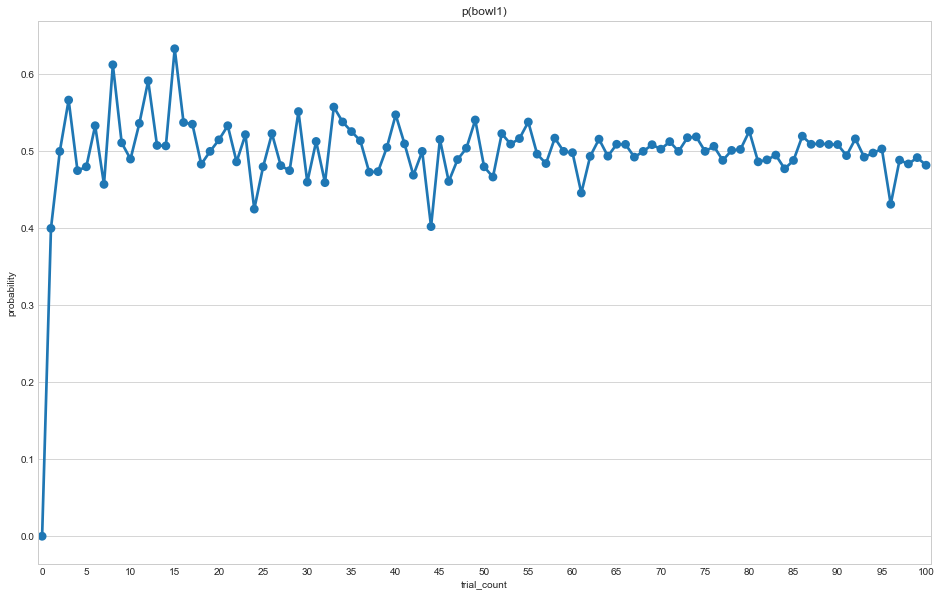

In [154]:
plt.figure(figsize=(16, 10))
ax = sns.pointplot(x="trial_count", y="probability", data=p_bowl1s_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_title("p(bowl1)")

## ここからは似たようなことを繰り返すだけなので説明を少し省く

## p(バニラ | ボウル1)

$$p(バニラ | ボウル1) = [ボウル1のバニラの数] / [ボウル1のクッキーの数]　= 30 / 40 = 3/4 $$

In [155]:
cookies_in_bowl1 = []
[cookies_in_bowl1.append("v") for x in range(30)] # バニラ
[cookies_in_bowl1.append("c") for x in range(10)] # チョコ
bowl1_samples = random_sampling(cookies_in_bowl1, 1000)
p_bowl1_v = len([x for x in bowl1_samples if x == "v"]) / len(bowl1_samples)
p_bowl1_v # p(バニラ | ボウル1) => だいたい0.7〜0.8の間になる

0.762

## p(バニラ)

$$p(バニラ) = [全てのバニラの数] / [全てのクッキーの数] = (30 + 20) / (40 + 40) = 50/80 = 5/8 $$

In [156]:
cookies_in_bowl2 = []
[cookies_in_bowl2.append("v") for x in range(20)] # バニラ
[cookies_in_bowl2.append("c") for x in range(20)] # チョコ
cookies_in_bowls = cookies_in_bowl1 + cookies_in_bowl2
bowls_samples = random_sampling(cookies_in_bowls, 1000)
p_v = len([x for x in bowls_samples if x == "v"]) / len(bowls_samples)
p_v # p(バニラ) => だいたい0.58〜0.68の間になる

0.611

## p(ボウル1|バニラ)

$$p(ボウル1|バニラ) = \dfrac{(1/2) \times (3/4)}{5/8} = 3/5$$

最後にベイズの定理で求めた上記の確率を確かめてみる。

In [157]:
cookies_with_bowl_number = [[1, x] for x in cookies_in_bowl1] + [[2, x] for x in cookies_in_bowl2]
cookies_samples = random_sampling(cookies_with_bowl_number, 1000) # 1000回サンプリングしてみる
v_samples = [x for x in cookies_samples if x[1] == "v"] # サンプリングした内、バニラのクッキーのサンプルだけ抽出
v_bowl1_samples = [x for x in v_samples if x[0] == 1] # バニラのクッキーのサンプルの内、ボウル1のサンプルだけを抽出
p_bowl1_v = len(v_bowl1_samples) / len(v_samples) # 取り出したのがバニラのクッキーだった場合に、それがボウル1からだった場合の確率を計算する
p_bowl1_v # p(ボウル1 | バニラ) => だいたい0.55〜0.65の間になる

0.6125984251968504

試行回数を増やした場合の確率の推移を見てみる（1〜1,000を10刻み）

In [158]:
trial_counts = list(range(0, 1001, 10))
trial_counts[0] = 1

p_bowl1_vs = []
for count in trial_counts:
    cookies_samples = random_sampling(cookies_with_bowl_number, count)
    v_samples = [x for x in cookies_samples if x[1] == "v"] # サンプリングした内、バニラのクッキーのサンプルだけ抽出
    v_bowl1_samples = [x for x in v_samples if x[0] == 1] # バニラのクッキーのサンプルの内、ボウル1のサンプルだけを抽出
    p_bowl1_v = len(v_bowl1_samples) / len(v_samples)
    p_bowl1_vs.append([count, p_bowl1_v])
p_bowl1_vs
p_bowl1_vs_df = pd.DataFrame(p_bowl1_vs, columns=["trial_count", "probability"])
p_bowl1_vs_df.head()

,trial_count,probability
0,1,0.000000
1,10,0.600000
2,20,0.461538
3,30,0.611111
4,40,0.720000


可視化してみる。

最初はばらつきが大きいが、試行回数が増えるにつれて、期待している確率の3/5（＝0.6）に収束していくことがわかる。

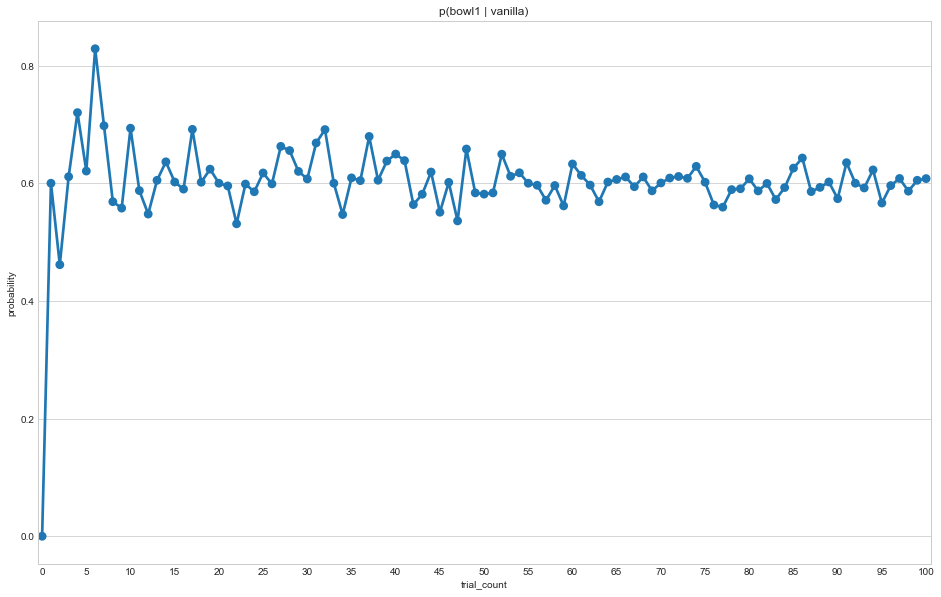

In [159]:
plt.figure(figsize=(16, 10))
ax = sns.pointplot(x="trial_count", y="probability", data=p_bowl1_vs_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_title("p(bowl1 | vanilla)")

# 参考資料

- 書籍: [Think Bayes](https://www.amazon.co.jp/Think-Bayes-―プログラマのためのベイズ統計入門-Allen-Downey/dp/4873116945) - 日本語で読める（有料）
- Website: [Think Bayes](http://greenteapress.com/wp/think-bayes/) - pdfもhtmlもあるけど英語（無料）
- 書籍: [Pythonで体験するベイズ推論 PyMCによるMCMC入門](https://www.amazon.co.jp/Pythonで体験するベイズ推論-PyMCによるMCMC入門-キャメロン-デビッドソン-ピロン/dp/4627077912) - pythonで具体的なコードが多くて面白い
